In [140]:
# conda activate Py39_R43_Ju10
# run step1-2 using Rscript

# #.libPaths(c('/sc/arion/projects/CommonMind/liting/conda/envs/Py39_R43_Ju10/lib/R/library',.libPaths()))
# .libPaths(c("/sc/arion/projects/roussp01a/jaro/programs/R_libs_4_2", .libPaths()))
# source('/sc/arion/projects/roussp01a/jaro/atacseq_ad/NYGC_AD_R01/downstream_magma.R')

[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__adhd"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__adhd_or_asd"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__als"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__als2021"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alz"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alz2"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alz2noapoe"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzKunkle"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzKunkleNoapoe"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzWightman"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzWightmanNoApoe"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzBellenguez"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__alzBellenguezNoApoe"
[1] "myGeneSets.ensemblProtCodGenes35kb10kbAutosomesNoBmhc__anorexia

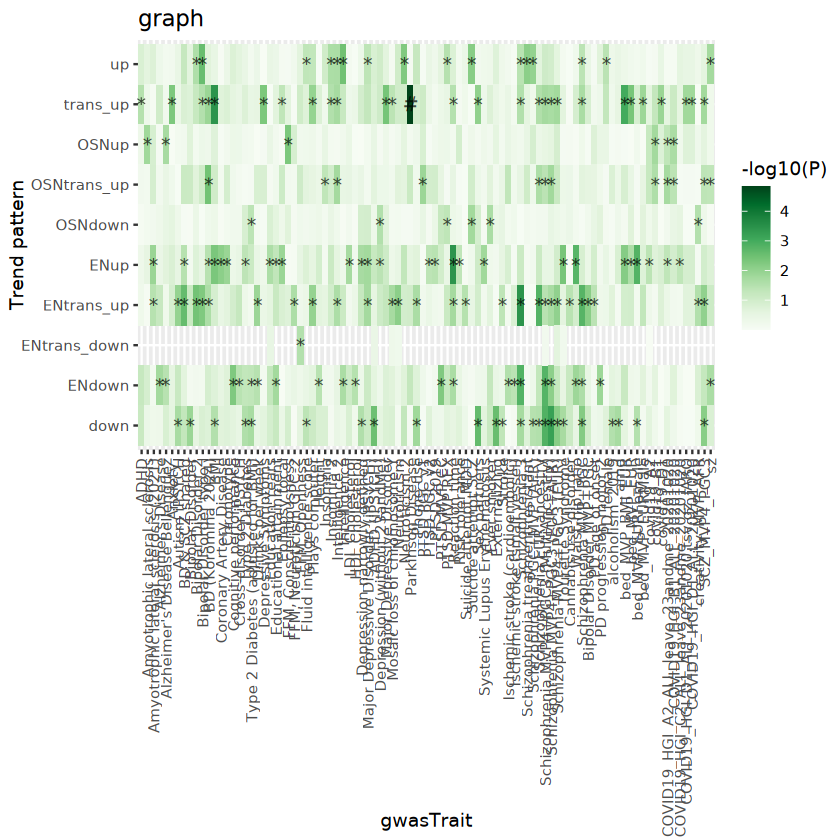

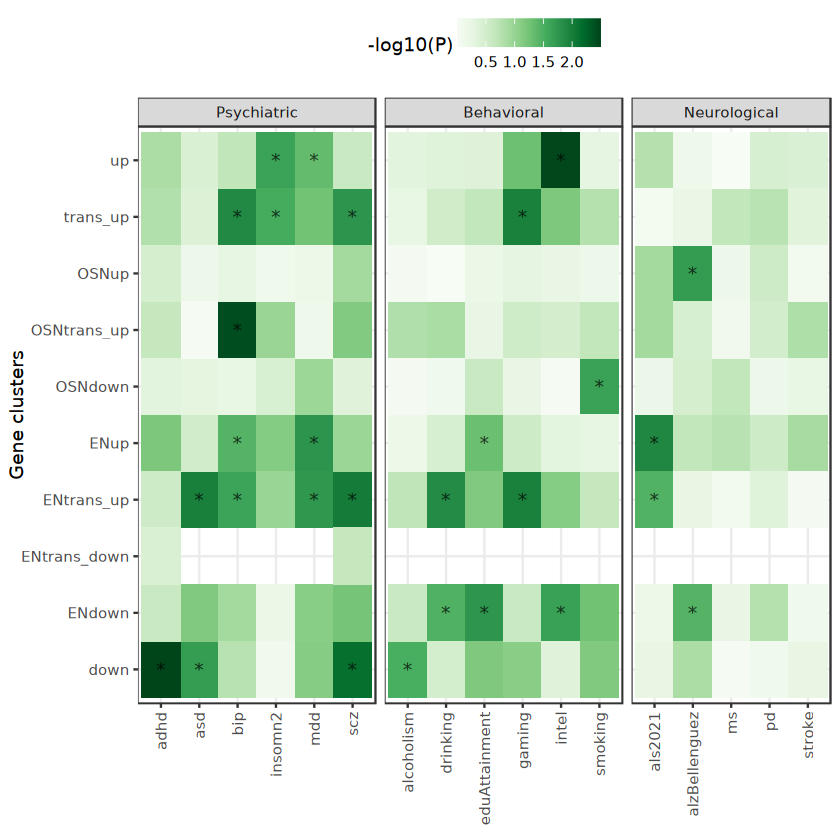

In [5]:
library(ggplot2)
library(stringr)
cMerge=function(df1,df2,col){cbind(df1,df2[match(df1[,col],df2[,col]),colnames(df2)!=col,drop=F])} #like built in merge fct but keeps order of rows and cols

magmaGeneSetResultReader=function(testID,outFile){
  print(testID)
  z=data.frame(testID=testID,read.table(outFile,comment.char="#",quote="",header=T,stringsAsFactors=F),stringsAsFactors=F)
  if("FULL_NAME" %in% colnames(z)){  #it is only in there if one ore more gene set names are truncated
    z$name=z$FULL_NAME
    z$FULL_NAME=NULL
  }else{
    if("SET" %in% colnames(z)){
      z$name=z$SET #magma v1.06
    }else{
      z$name=z$VARIABLE #magma v1.07
    }
  }
  z$SET=NULL
  z=z[order(z$P),]
  return(z)
}

doFdr=function(x){

  #library(fdrtool)
  #x$global_FDR_AdjP=fdrtool(x$P, statistic="pvalue", plot=F,cutoff.method="fndr",verbose=F)$qval
  x$global_Bonf_AdjP=p.adjust(x$P, method="bonferroni")
  x$global_BH_AdjP=p.adjust(x$P, method="BH")
  x$plotLabel=""
  x$plotLabel[x$P<0.05]="*"
  x$plotLabel[x$global_BH_AdjP<0.05]="#"

  return(x)
}


# gene cluster or gene trend


clusterx <- c('magma_graph_trend','magma_graph_cluster',"magma_tf_targets",'magma_de_overlap','magma_demerge_overlap')[5]

testInfo <- read.delim(paste0('/sc/arion/projects/CommonMind/liting/ENT/',clusterx,'/meta-files/testInfo.tsv'))
geneSetResults=do.call(rbind,mapply(magmaGeneSetResultReader,testInfo$testID,testInfo$outFile,SIMPLIFY=F,USE.NAMES=F))

#add most relvant cols from testInfo
geneSetResults=cMerge(geneSetResults,testInfo[,colnames(testInfo) %in% c("geneMetaSets","geneTypeName","gwasAcronym","gwasTrait", "testID"),drop=F],"testID")

#convert gwas acronyms to ordered factors for proper plotting
geneSetResults$gwasAcronym=ordered(geneSetResults$gwasAcronym,levels=unique(geneSetResults$gwasAcronym))
geneSetResults$gwasTrait=ordered(geneSetResults$gwasTrait,levels=unique(geneSetResults$gwasTrait))


geneSetGroupAggOverview=unique(geneSetResults[,c("geneTypeName","geneMetaSets")])
geneSetGroupAggOverview$aggID=make.names(apply(geneSetGroupAggOverview,1,paste,collapse=" "))
if(any(duplicated(geneSetGroupAggOverview$aggID))) stop("unfortunate combination of geneTypeName and geneMetaSets led to duplicated aggID")
rownames(geneSetGroupAggOverview)=geneSetGroupAggOverview$aggID



# file filter
# merged dataset

doGeneSetGroupAgg=function(aggID,geneTypeName,geneMetaSets){
  z=geneSetResults[geneSetResults$geneTypeName==geneTypeName & geneSetResults$geneMetaSets==geneMetaSets   ,] # & grepl('inner|outer',geneSetResults$VARIABLE)
  z$aggID=aggID
  z=doFdr(z)
  return(z)
}
geneSetGroupAgg=mapply(doGeneSetGroupAgg,geneSetGroupAggOverview$aggID,geneSetGroupAggOverview$geneTypeName,geneSetGroupAggOverview$geneMetaSets,SIMPLIFY=F)

geneSetGroupAgg_rs <- geneSetGroupAgg$ensemblProtCodGenes35kb10kbAutosomesNoBmhc.myGeneSets
sig_gwasTrait <- subset(geneSetGroupAgg_rs,P < 0.05 )[,'gwasTrait']
#sig_gwasTrait <- subset(geneSetGroupAgg_rs,global_BH_AdjP < 0.1)[,'gwasTrait']
#geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs,gwasAcronym%in%unlist(mytraits))
geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs, gwasTrait%in%sig_gwasTrait)

library(RColorBrewer)
myPalette = colorRampPalette(brewer.pal(9, "Greens"), space="Lab")
#myPalette2way=colorRampPalette(rev(c("#67001F","#B2182B","#D6604D","#F4A582","#FDDBC7","#F7F7F7","#D1E5F0","#92C5DE","#4393C3","#2166AC","#053061")), space="Lab")


ggplot(geneSetGroupAgg_rs_sig, aes(x=gwasTrait, y=VARIABLE))+
  geom_tile(aes(fill=-log10(P))) +
  scale_fill_gradientn(colours = myPalette(100))+
  geom_text(aes(label=plotLabel),alpha=0.7)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+ylab('Trend pattern')+
  ggtitle('graph')

# #plotAndAggMagma(myInput='/sc/arion/projects/CommonMind/liting/ENT/magma',outDir='/sc/arion/projects/CommonMind/liting/ENT/magma', calcFdr=T )
#
#
# dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/magma_trend.pdf')
#


# # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#

# mytraits=list(`Psychiatric`=c("sz3",'asd',"ptsd_1",'adhd_ipsych',"mdd2",'asd_ipsych', "bip",'insomn2', "bdAndSczShared", 'mdd_without_23andMe',"adhd", "neu2"),
#               Behavioral=c("drinking", "smoking",'eduAttainment','alcoholism_2019','child_intel','gaming'),
#               Neurological=c('alz2','als','ms','pd_without_23andMe','stroke'),
#               `Non-brain related`=c('bmi','height',"covid19_A1", "covid19_A2", "covid19_B1", "covid19_B2")
# )


# mytraits=list(`Psychiatric`=c('scz_mvp4_pgc3_eur_afr','adhd_ipsych',"mdd2",'asd_ipsych', "bip_koromina_2024",'insomn2', "bdAndSczShared"),
#               Behavioral=c("drinking", "smoking",'eduAttainment','alcoholism_2019',"intel",'gaming'),
#               Neurological=c('alz2','als','ms','pd_without_23andMe','stroke')
#               #`Non-brain related`=c('bmi','height',"covid19_A1", "covid19_A2", "covid19_B1", "covid19_B2")
# )


mytraits=list(`Psychiatric`=c('scz_mvp4_pgc3_eur','adhd_ipsych',"mdd_ipsych",'asd_ipsych', "bip_koromina_2024",'insomn2'),
              Behavioral=c("drinking", "smoking",'eduAttainment','alcoholism_2019',"intel",'gaming'),
              Neurological=c('alzBellenguez','als2021','ms','pd_without_23andMe','stroke')#,
              #`Non-brain related`=c('bmi','height',"covid19_A1", "covid19_A2", "covid19_B1", "covid19_B2")
)

gwas_info <- unique(subset(testInfo, gwasAcronym%in%unlist(mytraits))[,c('gwasAcronym','gwasTrait','gwasUrl', 'gwasArticle','gwasPubmed','gwasAncestry' )])
write.table(gwas_info, file='./data/gwas_info.txt',sep='\t',quote = F)

mytraits_df <- data.frame()
for (term in names(mytraits)){
  disease <- mytraits[[term]]
  df <- cbind(rep(term, length(disease)),disease)
  mytraits_df <- rbind( mytraits_df,df)
}

rownames(mytraits_df) <- mytraits_df$disease


geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs,gwasAcronym%in%unlist(mytraits))

library(RColorBrewer)
myPalette = colorRampPalette(brewer.pal(9, "Greens"), space="Lab")
#myPalette2way=colorRampPalette(rev(c("#67001F","#B2182B","#D6604D","#F4A582","#FDDBC7","#F7F7F7","#D1E5F0","#92C5DE","#4393C3","#2166AC","#053061")), space="Lab")

geneSetGroupAgg_rs_sig$category <- factor(mytraits_df[as.character(geneSetGroupAgg_rs_sig$gwasAcronym),"V1"],levels = names(mytraits))
geneSetGroupAgg_rs_sig <- doFdr(geneSetGroupAgg_rs_sig)


geneSetGroupAgg_rs_sig$VARIABLE <- gsub('X','',geneSetGroupAgg_rs_sig$VARIABLE)
#save(geneSetGroupAgg_rs_sig, file='/sc/arion/projects/roussp01a/liting/Olf/data/magma_TF_tragets.RData')


ggplot(geneSetGroupAgg_rs_sig, aes(x=str_split(gwasAcronym,'_',simplify = T)[,1] , 
                                   y=VARIABLE
                                   #y=factor( str_to_title(VARIABLE), levels =str_to_title(c('down','trans_up','up','trans_down')))
))+
  geom_tile(aes(fill=-log10(P))) +theme_bw()+
  scale_fill_gradientn(colours = myPalette(100))+
  geom_text(aes(label=plotLabel),alpha=0.7)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position='top')+
  ylab('Gene clusters')+xlab('')+
  facet_grid(.~category,scales = 'free_x',space='free')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


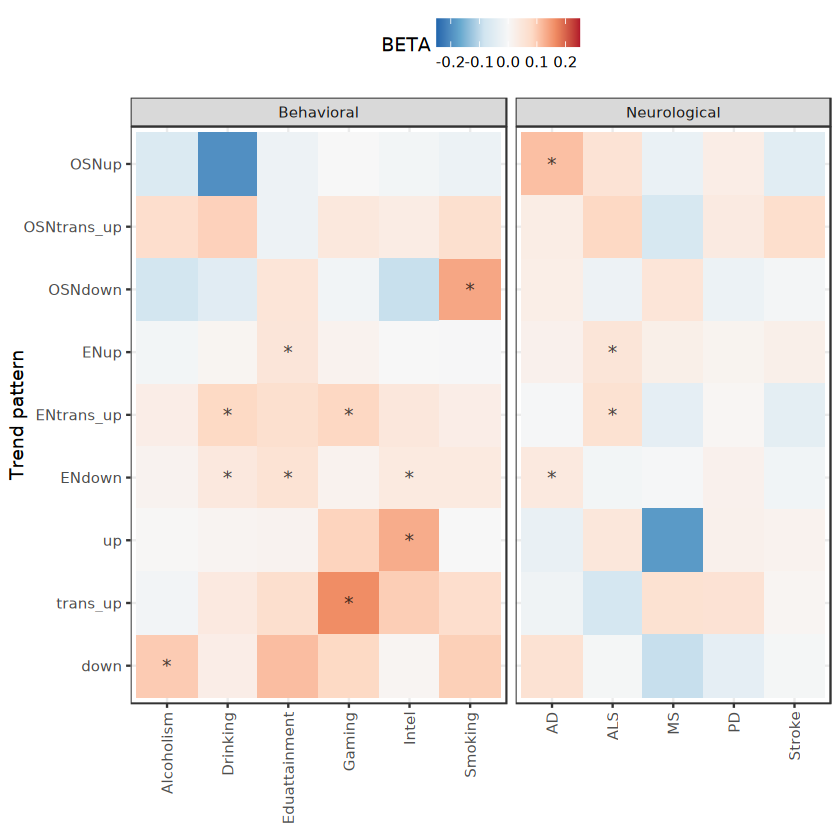

In [6]:
geneSetGroupAgg_rs_sig$gwasAcronym <- gsub('\\d','',geneSetGroupAgg_rs_sig$gwasAcronym)
geneSetGroupAgg_rs_sig$gwasAcronym <- str_split(geneSetGroupAgg_rs_sig$gwasAcronym,'_',simplify = T)[,1]
geneSetGroupAgg_rs_sig$gwasAcronym <- ifelse(geneSetGroupAgg_rs_sig$gwasAcronym%in%c('als','asd','adhd','bip','mdd','scz','als','pd','ms'),toupper(geneSetGroupAgg_rs_sig$gwasAcronym) ,
                                             str_to_title(geneSetGroupAgg_rs_sig$gwasAcronym) )
geneSetGroupAgg_rs_sig$gwasAcronym[geneSetGroupAgg_rs_sig$gwasAcronym=='Alzbellenguez'] <- 'AD'
#unique(geneSetGroupAgg_rs_sig$gwasAcronym)


ggplot(subset(geneSetGroupAgg_rs_sig,VARIABLE!='ENtrans_down' & category!='Psychiatric'), aes(x=str_split(gwasAcronym,'_',simplify = T)[,1] , 
                                   y=factor(VARIABLE,levels = c( 'down', 'trans_up','up','ENdown','ENtrans_up','ENup','OSNdown','OSNtrans_up','OSNup'))
                                  #y=factor( str_to_title(VARIABLE), levels =str_to_title(c('down','trans_up','up','trans_down')))
))+
  geom_tile(aes(fill=BETA)) +theme_bw()+
  scale_fill_gradient2()+
  geom_text(aes(label=plotLabel),alpha=0.7)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position='top')+
  ylab('Trend pattern')+xlab('')+scale_fill_distiller(palette = 'RdBu',limits = c(-0.25,0.25))+
  facet_grid(.~category,scales = 'free_x',space='free')

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/magma_trend_bytraitcat.pdf', width=7, height=5)

In [7]:
oe_trend <-  c('down','trans_down','up','trans_up')
oe_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(oe_color) <- oe_trend

geneSetGroupAgg_rs_sig$trend_pat <- gsub('N','N ' ,geneSetGroupAgg_rs_sig$name)
geneSetGroupAgg_rs_sig <- within(geneSetGroupAgg_rs_sig,{
    trend_cat <- 'Shared'
    trend_cat[grepl('EN',geneSetGroupAgg_rs_sig$name )] <- 'EN-specfic'
    trend_cat[grepl('OSN',geneSetGroupAgg_rs_sig$name )] <- 'OSN-specfic'
    trend_cat[is.na(trend_cat)] <- 'Shared'
    
} )

geneSetGroupAgg_rs_sig$trend <- gsub('EN|OSN','',geneSetGroupAgg_rs_sig$name)
geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs_sig,trend!='trans_down')



In [8]:
library(colorspace)
geneSetGroupAgg_rs_sig$plotLabel[geneSetGroupAgg_rs_sig$plotLabel=='*'] <- 'x'

pdf 
  2

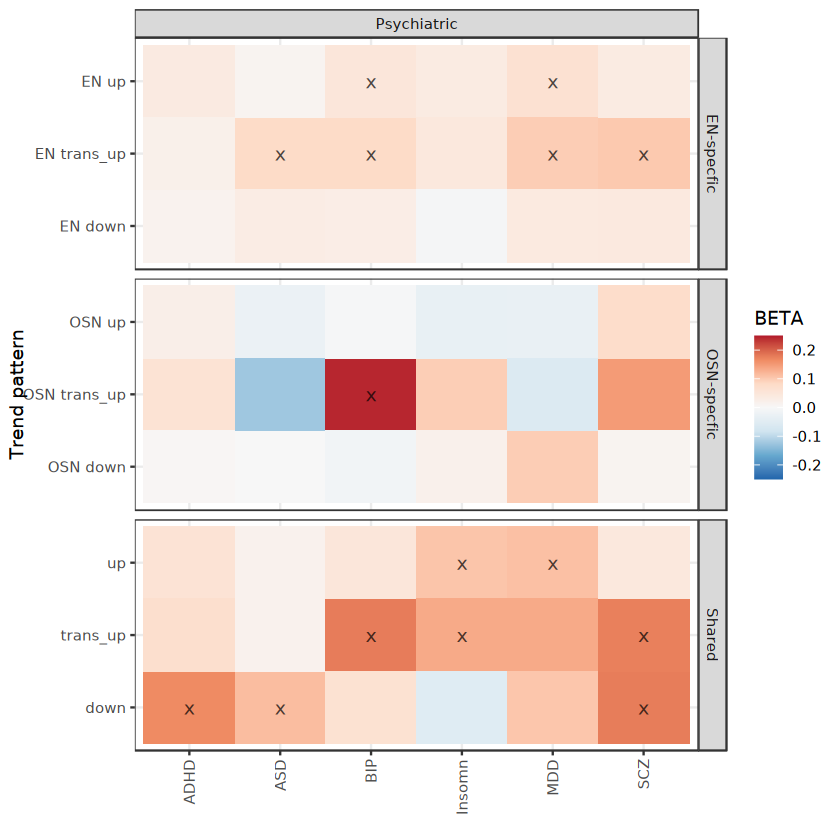

In [9]:
ggplot(subset(geneSetGroupAgg_rs_sig,VARIABLE!='ENtrans_down' & category=='Psychiatric'),
       aes(x=str_split(gwasAcronym,'_',simplify = T), 
           y=trend_pat))+
  geom_tile(aes(fill=BETA)) +theme_bw()+
#scale_fill_gradient2(low = 'blue',high = 'red')+
scale_fill_distiller(palette = 'RdBu',limits = c(-0.25,0.25))+
#scale_fill_continuous_divergingx(palette = 'RdBu', mid = 0,rev=T,   p3=0.8,p4=0.5)+
facet_grid(trend_cat~category,scales = 'free')+
  geom_text(aes(label=plotLabel),alpha=0.7)+
#col= colorRamp2(seq(from=min(xxxx),to=max(xxxx),length=9),rev(brewer.pal(11, "RdBu")[c(-1,-11)])),
#   scale_fill_gradient2()+
#   geom_text(aes(label=plotLabel),alpha=0.7)+
   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
   ylab('Trend pattern')+xlab('')#+
 # facet_grid(.~category,scales = 'free_x',space='free')
dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/psychiatric.magma.pdf',width=3.8, height=4)

pdf 
  2

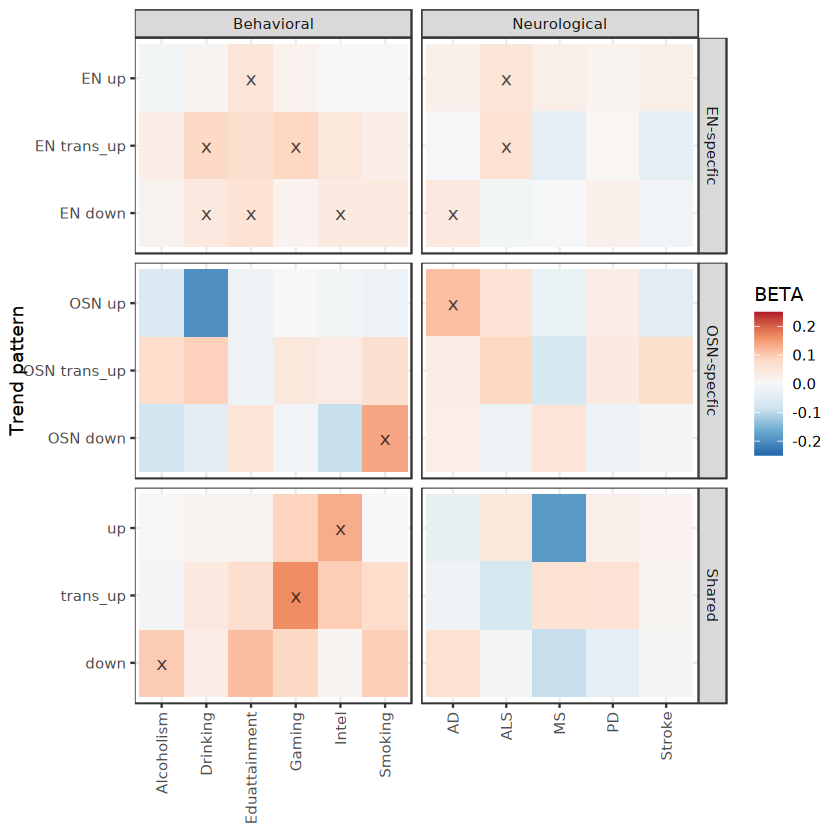

In [10]:
ggplot(subset(geneSetGroupAgg_rs_sig,VARIABLE!='ENtrans_down' & category!='Psychiatric'),
       aes(x=str_split(gwasAcronym,'_',simplify = T), 
           y=trend_pat))+
  geom_tile(aes(fill=BETA)) +theme_bw()+
#scale_fill_gradient2(low = 'blue',high = 'red')+
scale_fill_distiller(palette = 'RdBu',limits = c(-0.25,0.25))+
#scale_fill_continuous_divergingx(palette = 'RdBu', mid = 0,rev=T,   p3=0.8,p4=0.5)+
facet_grid(trend_cat~category,scales = 'free')+
  geom_text(aes(label=plotLabel),alpha=0.7)+
#col= colorRamp2(seq(from=min(xxxx),to=max(xxxx),length=9),rev(brewer.pal(11, "RdBu")[c(-1,-11)])),
#   scale_fill_gradient2()+
#   geom_text(aes(label=plotLabel),alpha=0.7)+
   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
   ylab('Trend pattern')+xlab('')#+
 # facet_grid(.~category,scales = 'free_x',space='free')

dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/neurological.magma.pdf',width=7, height=4)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


pdf 
  2

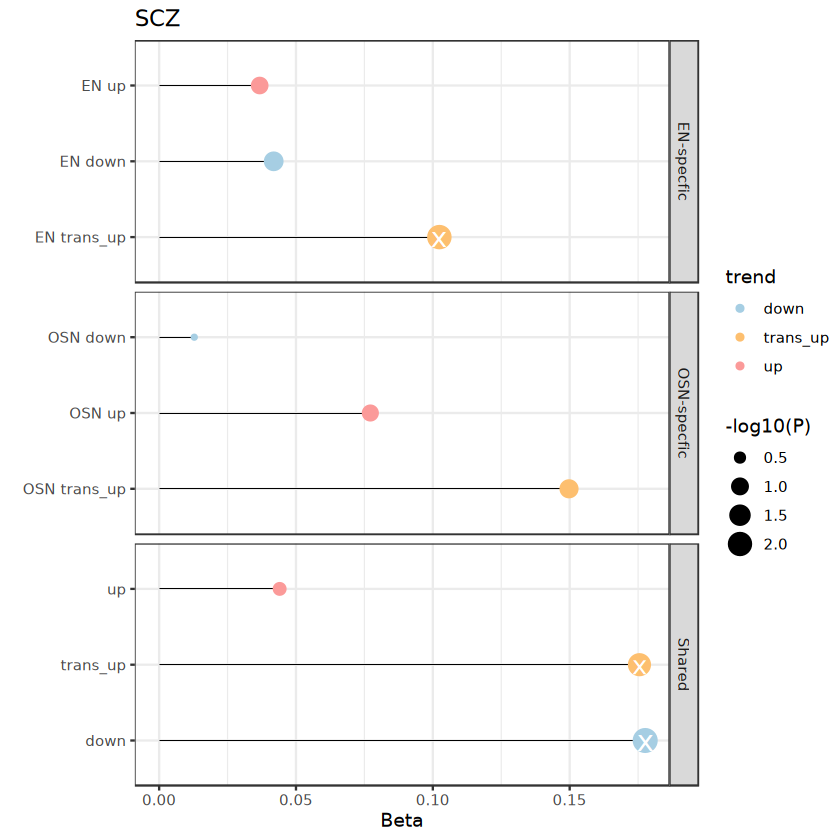

In [8]:

ggplot(subset(geneSetGroupAgg_rs_sig, gwasAcronym=='SCZ'), 
       aes(y=reorder(trend_pat,P),x=BETA,color=trend, size=-log10(P)))+
facet_grid(trend_cat~.,scales = 'free_y')+
geom_segment(aes(y = reorder(trend_pat,P), yend = reorder(trend_pat,P), x = 0, xend = BETA), 
               color = "black", size = 0.2)+theme_bw()+
geom_point()+
geom_text(aes(label=plotLabel), color='white',show.legend = FALSE)+
scale_color_manual(values = oe_color)+labs(x='Beta',y='',color='trend',title='SCZ')

dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/scz.magma.pdf',width=4, height=3.6)

In [148]:
geneSetGroupAgg_rs_sig$gwasAcronym <- gsub('\\d','',geneSetGroupAgg_rs_sig$gwasAcronym)
geneSetGroupAgg_rs_sig$gwasAcronym <- str_split(geneSetGroupAgg_rs_sig$gwasAcronym,'_',simplify = T)[,1]
geneSetGroupAgg_rs_sig$gwasAcronym <- ifelse(geneSetGroupAgg_rs_sig$gwasAcronym%in%c('als','adhd','bip','mdd','scz','als','pd','ms'),toupper(geneSetGroupAgg_rs_sig$gwasAcronym) ,str_to_title(geneSetGroupAgg_rs_sig$gwasAcronym) )
geneSetGroupAgg_rs_sig$gwasAcronym[geneSetGroupAgg_rs_sig$gwasAcronym=='Alzbellenguez'] <- 'AD'
#unique(geneSetGroupAgg_rs_sig$gwasAcronym)


In [149]:
oe_trend <-  c('down','trans_down','up','trans_up','')
en_trend <- c('down','trans_down','up','trans_up','')

oe_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(oe_color) <- oe_trend[1:4]

en_color <- brewer.pal(n = 8, name = "Paired")[c(2,4,6,8)]
names(en_color) <- en_trend[1:4]


In [150]:
library(ComplexHeatmap)
library(reshape2)
library(circlize)

## heatmap
dpp <- dcast(geneSetGroupAgg_rs_sig[,c("gwasAcronym", "name" ,"BETA")],name~gwasAcronym)

trend <- as.data.frame(str_split(dpp$name,pattern = '\\.',simplify = T))
trend$V1 <- gsub('EN','EN-specific ', trend$V1)
trend$V1 <- gsub('OSN','OSN-specific ', trend$V1)

trend$trend <- ifelse(trend$V1==trend$V2, paste0('Shared ', trend$V1),
                             ifelse(grepl('specific',trend$V1),trend$V1, paste0("OSN-",trend$V1,' ~ ','EN-', trend$V2)))
                            
trend$V2[grepl('^EN',trend$V1)] <- gsub("EN-specific ",'',trend$V1[grepl('^EN',trend$V1)])
trend$V1[grepl('^EN',trend$V1)] <- ''
trend$V1[grepl('^OSN',trend$V1)] <- gsub("OSN-specific ",'',trend$V1[grepl('^OSN',trend$V1)])
rownames(trend) <- trend$trend
rownames(dpp) <- rownames(trend)
dpp <- dpp[,-1]

disorder_cat <- unique(geneSetGroupAgg_rs_sig[,c("gwasAcronym","category")])
rownames(disorder_cat) <- disorder_cat$gwasAcronym
disorder_cat <- disorder_cat[order(disorder_cat$category),]
dis_color=brewer.pal(n = 12, name = "Set3")[1:3]
names(dis_color) <- unique(disorder_cat$category)

oe_trend <-  c('down','trans_down','up','trans_up','')
en_trend <- c('down','trans_down','up','trans_up','')

oe_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(oe_color) <- oe_trend[1:4]

en_color <- brewer.pal(n = 8, name = "Paired")[c(2,4,6,8)]
names(en_color) <- en_trend[1:4]

# order_pattern <- c(
#   'Shared down','OSN-down ~ EN-trans_down','OSN-down ~ EN-up','OSN-down ~ EN-trans_up','OSN-specific down',
#   'Shared trans_up','OSN-trans_up ~ EN-down','OSN-trans_up ~ EN-trans_down','OSN-trans_up ~ EN-up','OSN-specific trans_up',
#   'Shared trans_down','OSN-trans_down ~ EN-up','OSN-trans_down ~ EN-trans_up','OSN-specific trans_down',
#   'Shared up', 'OSN-up ~ EN-trans_up','OSN-up ~ EN-down', 'OSN-up ~ EN-trans_down', 'OSN-specific up',
#   'EN-specific down','EN-specific trans_up','EN-specific trans_down','EN-specific up'
#   
# )

order_pattern <- c(
  'Shared down','OSN-down ~ EN-trans_down','OSN-down ~ EN-trans_up','OSN-down ~ EN-up',
  'OSN-trans_up ~ EN-down','Shared trans_up','OSN-trans_up ~ EN-trans_down','OSN-trans_up ~ EN-up',
  'Shared trans_down','OSN-trans_down ~ EN-up','OSN-trans_down ~ EN-trans_up','OSN-specific trans_down',
  'OSN-up ~ EN-down', 'OSN-up ~ EN-trans_up', 'Shared up', 'OSN-up ~ EN-trans_down', 
  'EN-specific down','EN-specific trans_up','EN-specific trans_down','EN-specific up',
  'OSN-specific down','OSN-specific trans_up','OSN-specific up'
  
)

heatmap_input <- dcast(geneSetGroupAgg_rs_sig[,c("gwasAcronym", "name" ,"plotLabel")],name~gwasAcronym)[,-1]
rownames(heatmap_input) <- rownames(dpp)

dpp <- dpp[intersect(order_pattern, rownames(dpp)) , as.character(disorder_cat$gwasAcronym)]
dpp <- dpp[!grepl('trans_down', rownames(dpp)),]
heatmap_input <- heatmap_input[rownames(dpp),colnames(dpp)]



ht_list=Heatmap(
  dpp,
  na_col = "white",
  name='beta',
  col                          = colorRamp2(seq(from=-1,to=1,length=9),rev(brewer.pal(9, "RdBu"))),
  cluster_columns              = F,
  cluster_rows                 = F,
  show_row_names               = T,
  show_column_names            = T ,
  row_names_max_width = unit(15, "cm"),
  column_names_max_height  = unit(15, "cm"),
  cell_fun = function(j, i, x, y, width, height, fill) {
    grid.text(heatmap_input[i, j], x, y, gp = gpar(fontsize = 10))},
  top_annotation = HeatmapAnnotation(
    disorder_Cate=disorder_cat[colnames(dpp),'category'],
    col=list(disorder_Cate=dis_color)
  ),
  rect_gp = gpar(col = "grey", lwd = 0.5),
  left_annotation=rowAnnotation(
    # pattern=rownames(dpp),
    OSN_pattern = trend[rownames(dpp),'V1'],
    EN_pattern = trend[rownames(dpp),'V2'],
    col = list(OSN_pattern = oe_color,
               EN_pattern=en_color)
  ),
  # row_split = trend[rownames(dpp),'OSN']
  row_split = factor( c(rep('OSN down',3), rep('OSN trans_up',3),rep('OSN up',3),rep('EN specifc',3),rep('OSN specifc',3)),
                     levels = c("OSN specifc","EN specifc","OSN down"  ,   "OSN trans_up", "OSN up")),
  column_split =factor(c(rep('Psychiatric',6), rep('Behavioral',6),rep('Neurological',5)), levels = c("Psychiatric", "Behavioral", "Neurological")) ,
  show_heatmap_legend=F,show_column_dend = F, show_row_dend = F
  )


draw(ht_list, merge_legend = TRUE, heatmap_legend_side = "right", 
     annotation_legend_side = "right")


#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/magma_DEtrend_heatmap.pdf', width=8.8, height=5.5)

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.3.3”
Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Warning message:
“package ‘circlize’ was built under R version 4.3.3”
circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circ

ERROR: Error in `$<-.data.frame`(`*tmp*`, trend, value = logical(0)): replacement has 0 rows, data has 9


pdf 
  2

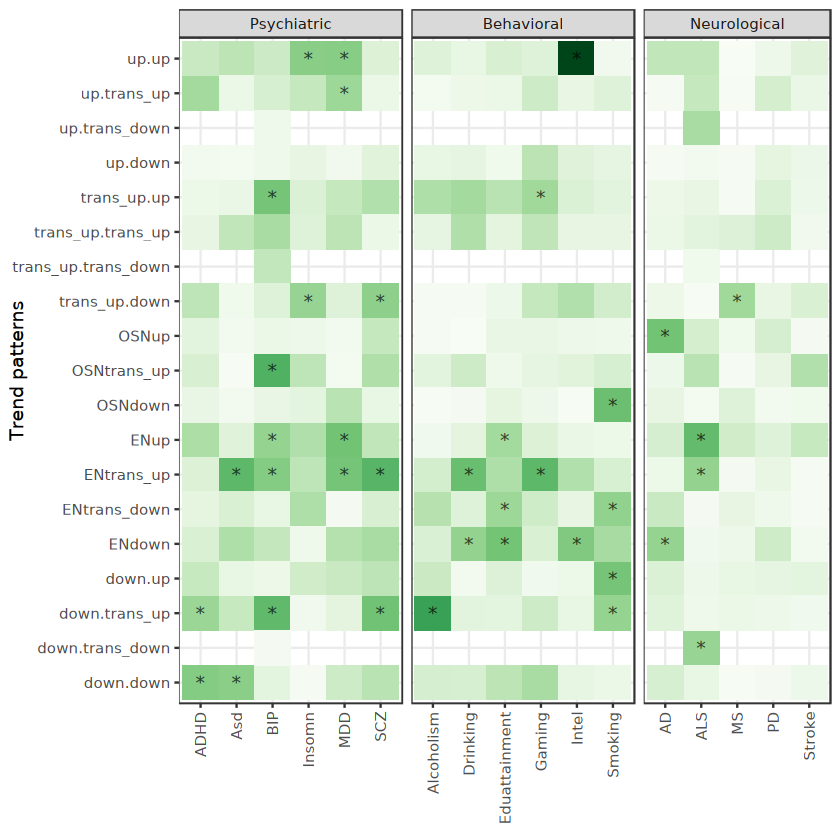

In [46]:
ggplot(geneSetGroupAgg_rs_sig, aes(x=str_split(gwasAcronym,'_',simplify = T)[,1] , 
                                   y=VARIABLE
                                   #y=factor( str_to_title(VARIABLE), levels =str_to_title(c('down','trans_up','up','trans_down')))
))+
  geom_tile(aes(fill=-log10(P))) +theme_bw()+
  scale_fill_gradientn(colours = myPalette(100))+
  geom_text(aes(label=plotLabel),alpha=0.7)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position='up')+ylab('Trend patterns')+xlab('')+
  facet_grid(.~category,scales = 'free_x',space='free')

dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/magma_cluster_bytraitcat.pdf', width=5, height=3.5)